# <center>Machine Learning and Data Mining</center>

## <center>Group project: Expedia Hotel Recommendations</center>

### <center>Students: *Maxim Demidov, Vasiliy Mosin, German Sokolov*</center>

Expedia has provided logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

Our goal is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

In [2]:
import random
import operator
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import naive_bayes
from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis  import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn-whitegrid')
pd.options.mode.chained_assignment = None

**Load data**

The data contains Expedia users' logs (both ended with booking and just views) and it is too large (8+ GB) to operate it on a single laptop.
<br>

To overcome this problem - let's take only those logs which ended with bookings (≈0.5 GB). We consider them as the most important part of the data.

In [4]:
#url = '/Users/imac/Desktop/train_booked.csv'
#url_destin = '/Users/imac/Desktop/destinations.csv'
#url_destin = "/home/hpish/Data/destinations.csv"
url_destin = 'destinations.csv'
url = 'train_booked.csv'
#url = "/home/hpish/Data/train_booked.csv"
#url_destin = 'https://www.dropbox.com/s/b261x4d34jsqd2g/destinations.csv?dl=1'
#url = 'https://www.dropbox.com/s/6z0svhusvw3cb5v/train.csv?dl=1'
train = pd.read_csv(url)
destin = pd.read_csv(url_destin)

In [12]:
train.head(2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
1,2014-02-27 18:01:32,2,3,66,318,52078,NaN,756,0,1,...,0,1,8291,1,1,1,2,50,191,2


In [13]:
print('Train data size {:,} x {}'.format(train.shape[0], train.shape[1]))
print('Number of unique users {:,}'.format(pd.unique(train.user_id).shape[0]))

Train data size 3,000,693 x 24
Number of unique users 813,985


**Data visualization**

The goal is to predict user's hotel cluster - target feature. <br>
Histogram of hotel clusters:

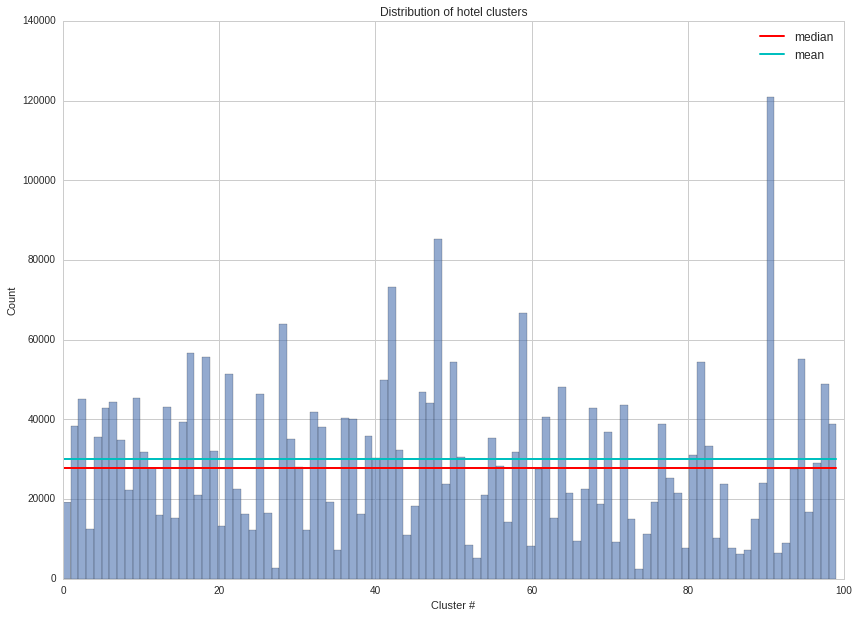

In [14]:
plt.figure(figsize=(14, 10))
plt.hist(train.hotel_cluster, bins=len(pd.unique(train.hotel_cluster)), alpha = 0.6)
# Median value of class sizes
plt.plot(np.arange(0,100), np.ones(100) * np.median(train.hotel_cluster.value_counts()), 'r-', lw = 2.)
plt.plot(np.arange(0,100), np.ones(100) * np.mean(train.hotel_cluster.value_counts()), 'c-', lw = 2.)
plt.title('Distribution of hotel clusters'); plt.xlabel('Cluster #'); plt.ylabel('Count')
plt.legend(['median', 'mean'], fontsize = '12'); plt.show()

* Target classes are unbalanced.

Plot values of some features as a function of time.

In [5]:
# Convert dates to pandas date-time format
train.date_time = pd.to_datetime(train.date_time)
train.srch_ci = pd.to_datetime(train.srch_ci)
train.srch_co = pd.to_datetime(train.srch_co)
# Remove time
train.date_time = train.date_time.apply(pd.datetools.normalize_date)

In [6]:
# Aggregate (sum function) data by date
TrainAggrSumByDate = pd.groupby(train[['date_time', 'is_mobile', 'is_package', 'is_booking']], 
                                by = 'date_time').aggregate(sum)

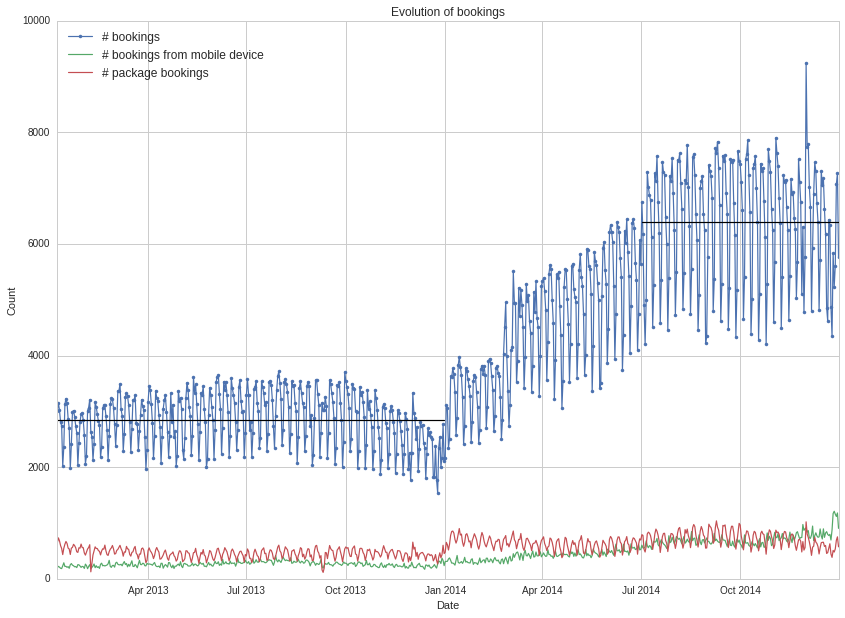

In [17]:
# Plot data
plt.figure(figsize=(14, 10))
x = TrainAggrSumByDate.index
plt.plot(x, TrainAggrSumByDate.is_booking, '.-', lw = 1.2)
plt.plot(x, TrainAggrSumByDate.is_mobile, '-', lw = 1.2)
plt.plot(x, TrainAggrSumByDate.is_package, '-', lw = 1.2)
plt.plot(x[x < '2014-01-01'], 
         np.ones(len(x[x < '2014-01-01'])) * np.mean(TrainAggrSumByDate.is_booking[x < '2014-01-01']), 'k-', lw = 1.2)
plt.plot(x[x > '2014-07-01'], 
         np.ones(len(x[x > '2014-07-01'])) * np.mean(TrainAggrSumByDate.is_booking[x > '2014-07-01']), 'k-', lw = 1.2)
plt.title('Evolution of bookings'); plt.xlabel('Date'); plt.ylabel('Count')
plt.legend(['# bookings','# bookings from mobile device', '# package bookings'], 
           loc = 'best', fontsize = 12)
plt.show()

* Number of bookings time series has significantly changed its level over time - almost 2x increase since Jan-2014.
* Bookings from mobile device have positive growth trend from the beginning of history.
* Package bookings fluctuate around one level.

In [7]:
# Aggregate (mean function) data by date
TrainAggrMeanByDate = pd.groupby(train[['date_time', 'orig_destination_distance']], 
                                 by = 'date_time').aggregate(np.mean)

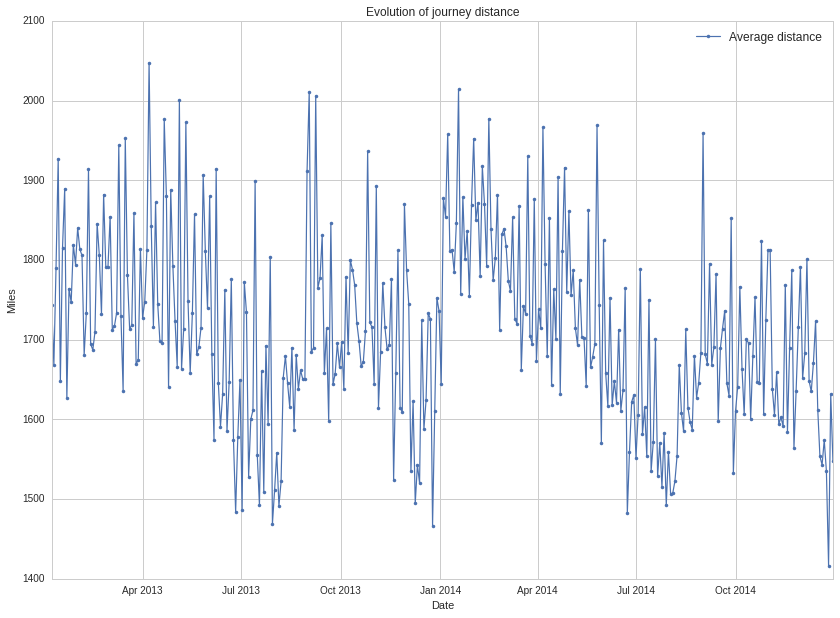

In [19]:
# Plot data
plt.figure(figsize=(14, 10))
x = TrainAggrMeanByDate.index
plt.plot(x[::2], TrainAggrMeanByDate.orig_destination_distance[::2], '.-', lw = 1.2)
plt.title('Evolution of journey distance'); plt.xlabel('Date'); plt.ylabel('Miles')
plt.legend(['Average distance'], loc = 'best', fontsize = 12)
plt.show()

* Average journey distance has clear seasonality - it plummets in summer. Construction of additional features like season might be helpful.   

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:894: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


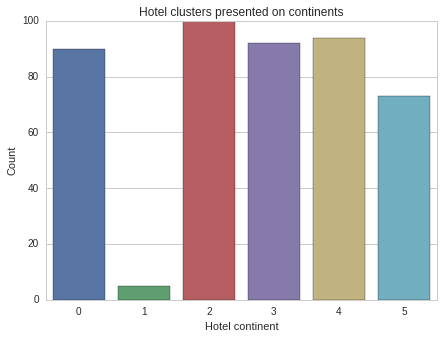

In [20]:
# Plot data
plt.figure(figsize=(7, 5))
y = [train[train.hotel_continent == i].hotel_cluster.value_counts().shape[0] for i in range(6)]
sns.barplot(np.arange(6), y)
plt.title('Hotel clusters presented on continents'); plt.xlabel('Hotel continent'); plt.ylabel('Count')
plt.show()

* Not all clusters are presented on each of continents - this fact can narrow potential number of classes to choose from.

In [8]:
# Aggregate (mean function) data by date
TrainAggrMeanByClust = pd.groupby(train[['hotel_cluster', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt']], 
                                 by = 'hotel_cluster').aggregate(np.mean)

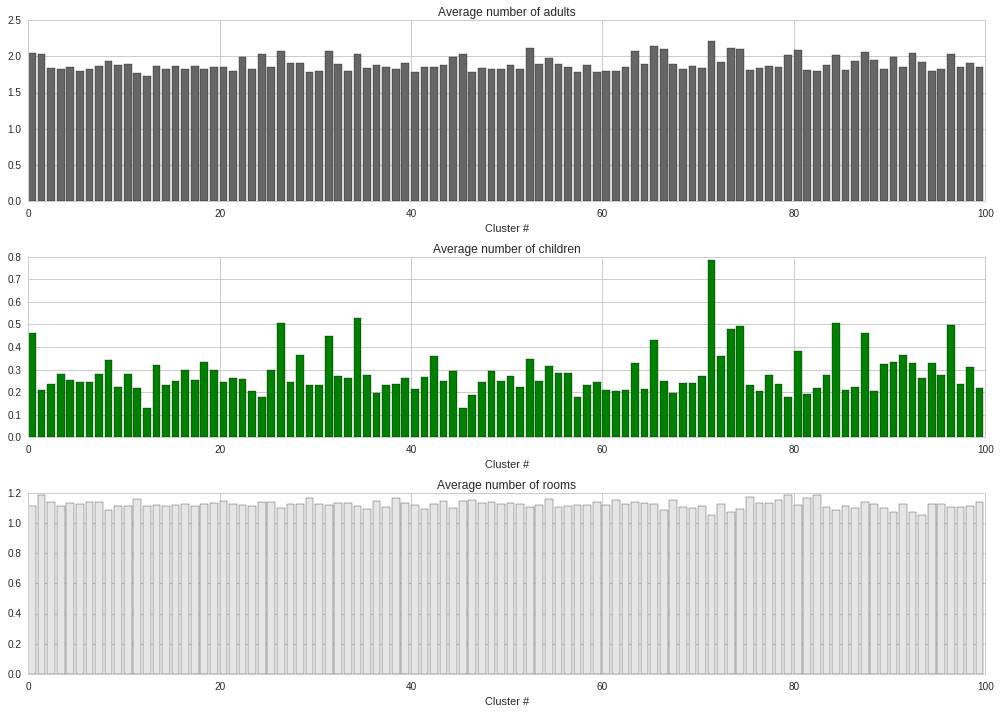

In [22]:
# Plot data
x = TrainAggrMeanByClust.index.values
plt.figure(figsize=(14, 10))
plt.subplot(311)
plt.bar(x, TrainAggrMeanByClust.srch_adults_cnt, facecolor = '0.4')
plt.title('Average number of adults'); plt.xlabel('Cluster #') 

plt.subplot(312)
plt.bar(x, TrainAggrMeanByClust.srch_children_cnt, facecolor = 'green')
plt.title('Average number of children'); plt.xlabel('Cluster #') 

plt.subplot(313)
plt.bar(x, TrainAggrMeanByClust.srch_rm_cnt, facecolor = '.9')
plt.title('Average number of rooms'); plt.xlabel('Cluster #') 
plt.tight_layout()
plt.show()

* Mean number of children in search could be valuable feature, as it highly depends on hotel cluster.
* Two others atttributes do not have much variability among target classes.

One more interesting attribute - type of destination.

In [ ]:
# Initialize matrix
ClustDestMatr = np.zeros((9, 100), dtype=int)
# Count number of clusters for each type of destinations
TrainAggrSumByClust = pd.groupby(train[['srch_destination_type_id', 'hotel_cluster', 'is_booking']], 
                                 by = ['srch_destination_type_id', 'hotel_cluster']).aggregate('sum')
DestTypes = pd.unique(train.srch_destination_type_id)
for i in range(len(DestTypes)):
    iCluster = TrainAggrSumByClust.loc[TrainAggrSumByClust.index.get_level_values('srch_destination_type_id') == DestTypes[i]]
    for j in iCluster.index.get_level_values('hotel_cluster'):
        ClustDestMatr[i, j] = iCluster.loc[iCluster.index.get_level_values('hotel_cluster') == j].is_booking  

# Normalize to get relative values 
ClustDestMatr = ClustDestMatr / np.array([np.repeat(i, 100) for i  in ClustDestMatr.sum(axis=1)])

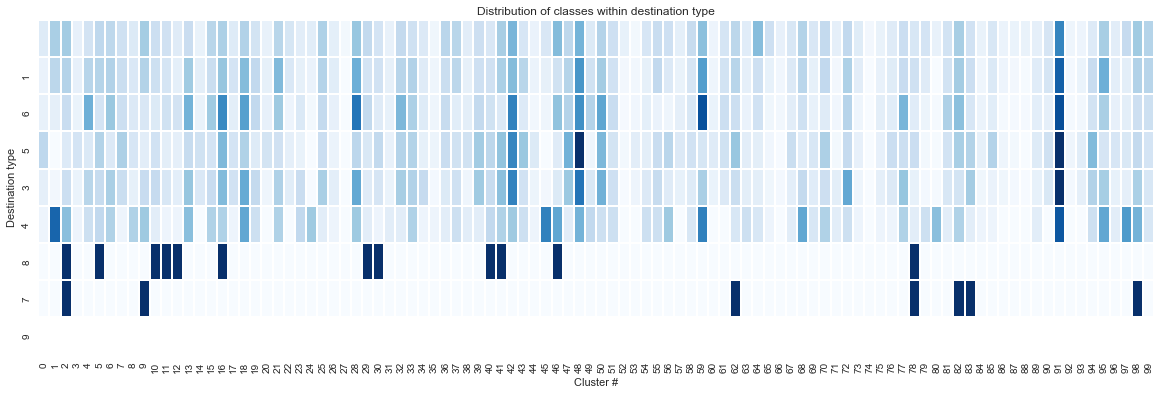

In [15]:
# Plot matrix
plt.figure(figsize=(20,6))
sns.heatmap(ClustDestMatr, linewidths=1, yticklabels = DestTypes, vmax=0.05, cmap='Blues', cbar = False)
plt.title('Distribution of classes within destination type')
plt.xlabel('Cluster #'); plt.ylabel('Destination type')
plt.show()

* Destination type zero corresponds to the single observation - hence this category might be excluded from the feature values.
* Generally, target class significantly depends on destination type. 

There is another portion of data available, which contains hotel search latent attributes. They were extracted from hotel reviews text.

In [16]:
destin.head(2)

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690


Explained variance: 56.9%


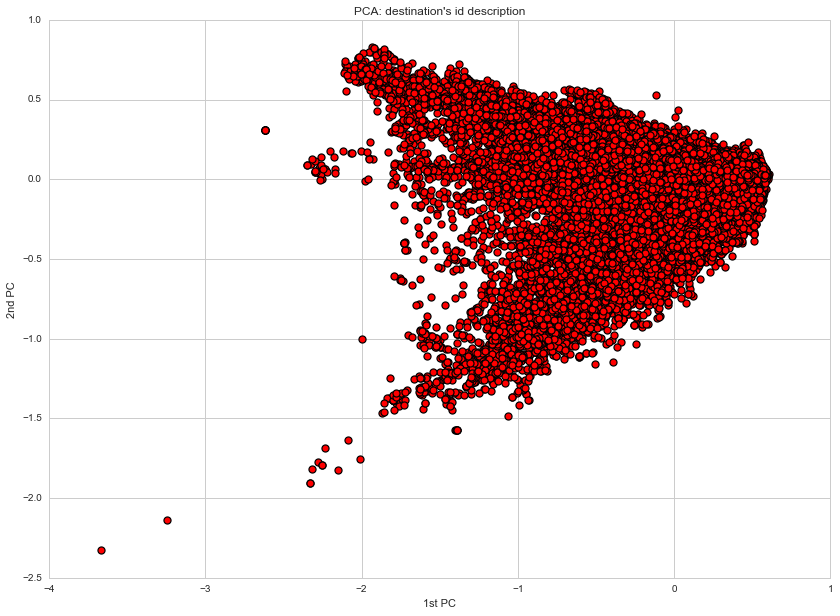

In [9]:
pca = PCA(n_components = 2)
pca.fit(destin.ix[:, 1:])
pca_comps = pca.transform(destin.ix[:, 1:])
print("Explained variance: {:.1f}%". format(sum(pca.explained_variance_ratio_) * 100))

# Plot PCA comps
plt.figure(figsize=(14, 10))
plt.scatter(x = pca_comps[:, 0], y = pca_comps[:, 1], color = 'red', 
            edgecolors='black', s = 50, linewidths = 1.2)
plt.title("PCA: destination's id description"); plt.xlabel('1st PC'); plt.ylabel('2nd PC')
plt.show()

*Important:* some destination ids don't exist in the destinations data. This is because some hotels are new and don't have enough features in the latent space. More precisely, the share of such ids is almost negligible and we will handle it later.

In [10]:
print('{:.2f}% as a share of total unique dest ids'.
      format(len(set.difference(set(pd.unique(train.srch_destination_id)), 
      set(pd.unique(destin.srch_destination_id)))) /
      len(pd.unique(train.srch_destination_id)) * 100))

print('{:.3f}% as a share of train data'. 
      format(train.srch_destination_id.isin(list(set.difference(set(pd.unique(train.srch_destination_id)), 
      set(pd.unique(destin.srch_destination_id))))).sum() / train.shape[0]))

1.01% as a share of total unique dest ids
0.004% as a share of train data


**Data preprocessing**

First, we need to resample our classes:
As they are distributed, we cannot learn properly

In [10]:
a = 1/train.groupby('hotel_cluster').size()
cl_weights = map(lambda x: a[x] ,train['hotel_cluster'])
train['weights'] = cl_weights

In [11]:
train = train.sample(n=1000000,replace = True,weights = 'weights')
train.drop(['weights'], inplace = True, axis = 1)

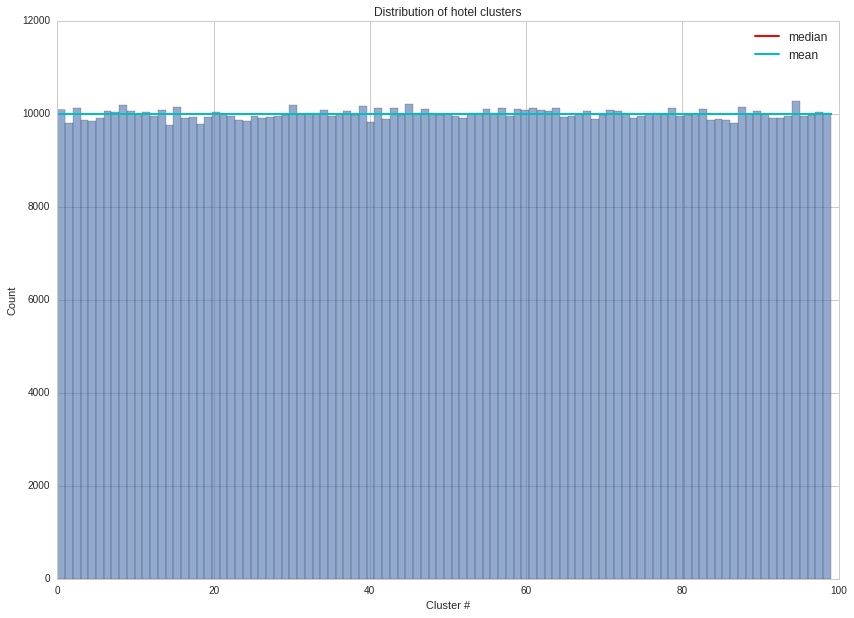

In [31]:
plt.figure(figsize=(14, 10))
plt.hist(train.hotel_cluster, bins=len(pd.unique(train.hotel_cluster)), alpha = 0.6)
# Median value of class sizes
plt.plot(np.arange(0,100), np.ones(100) * np.median(train.hotel_cluster.value_counts()), 'r-', lw = 2.)
plt.plot(np.arange(0,100), np.ones(100) * np.mean(train.hotel_cluster.value_counts()), 'c-', lw = 2.)
plt.title('Distribution of hotel clusters'); plt.xlabel('Cluster #'); plt.ylabel('Count')
plt.legend(['median', 'mean'], fontsize = '12'); plt.show()

That is better- the classes are distributed more evenly, so the classification will be more representative

Check integrity of destinations data.

In [35]:
print("Nans: {}".format(pd.isnull(destin).sum().sum()))

Nans: 0


* Destinations data do not have missing (NaN) values.

Now let's have a look at the train data.

In [36]:
train.columns

Index([u'date_time', u'site_name', u'posa_continent', u'user_location_country',
       u'user_location_region', u'user_location_city',
       u'orig_destination_distance', u'user_id', u'is_mobile', u'is_package',
       u'channel', u'srch_ci', u'srch_co', u'srch_adults_cnt',
       u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id',
       u'srch_destination_type_id', u'is_booking', u'cnt', u'hotel_continent',
       u'hotel_country', u'hotel_market', u'hotel_cluster'],
      dtype='object')

In [37]:
print('---Nans in columns---', '\n')
for col in train.columns:
    print(col + ": {}".format(pd.isnull(train[col]).sum()))

('---Nans in columns---', '\n')
date_time: 0
site_name: 0
posa_continent: 0
user_location_country: 0
user_location_region: 0
user_location_city: 0
orig_destination_distance: 353619
user_id: 0
is_mobile: 0
is_package: 0
channel: 0
srch_ci: 0
srch_co: 0
srch_adults_cnt: 0
srch_children_cnt: 0
srch_rm_cnt: 0
srch_destination_id: 0
srch_destination_type_id: 0
is_booking: 0
cnt: 0
hotel_continent: 0
hotel_country: 0
hotel_market: 0
hotel_cluster: 0


Cool. There is single feature, which has missing values - distance to destination.
<br>
Let's apply 2-steps procedure to handle this issue:

1. Replace NaNs with mean distance for given pair (user's region, destination id)

    *if there are still NaNs: *

2. Replace NaNs with mean distance for given pair (user's country, destination id)

First step.

In [11]:
# Aggregate data
TrainAggrMeanByRegToDest = pd.groupby(train[['user_location_region', 
                                            'srch_destination_id', 
                                            'orig_destination_distance']], 
                                      by = ['user_location_region', 'srch_destination_id']).aggregate('mean')
# Iterate over rows and replace Nans
print ("----Processing---")
for i in range(train.shape[0]):
    if i % 1000000 == 0:
        print (i, '/', train.shape[0])
    if ~ pd.isnull(train.orig_destination_distance.iat[i]): continue
    iUserReg = train.user_location_region.iat[i]
    iDestId = train.srch_destination_id.iat[i]
    iDistMean = TrainAggrMeanByRegToDest.loc[iUserReg, iDestId]
    train.orig_destination_distance.iat[i] = iDistMean

----Processing---
0 / 100693


There are still too many Nans after first step.

In [39]:
print('---Nans in columns---', '\n')
print('orig_destination_distance' + ": {}".format(pd.isnull(train['orig_destination_distance']).sum()))

('---Nans in columns---', '\n')
orig_destination_distance: 272138


In [12]:
# Aggregate data
TrainAggrMeanByCountrToDest = pd.groupby(train[['user_location_country', 
                                                'srch_destination_id', 
                                                'orig_destination_distance']], 
                                      by = ['user_location_country', 'srch_destination_id']).aggregate('mean')

# Iterate over rows and replace Nans
print ("----Processing---")
for i in range(train.shape[0]):
    if i % 1000000 == 0:
        print (i, '/', train.shape[0])
    if ~ pd.isnull(train.orig_destination_distance.iat[i]): continue
    iUserCountr = train.user_location_country.iat[i]
    iDestId = train.srch_destination_id.iat[i]
    iDistMean = TrainAggrMeanByCountrToDest.loc[iUserCountr, iDestId]
    train.orig_destination_distance.iat[i] = iDistMean

----Processing---
0 / 100693


In [41]:
print('---Nans in columns---', '\n')
print('orig_destination_distance' + ": {}".format(pd.isnull(train['orig_destination_distance']).sum()))

('---Nans in columns---', '\n')
orig_destination_distance: 217533


Replace the rest Nans with global mean distance.

In [13]:
train.orig_destination_distance[pd.isnull(train.orig_destination_distance)] = train.orig_destination_distance.mean()

**Feature engineering**

Split target feature from training features.

In [14]:
y = train.hotel_cluster
x = train.ix[:, :-1]

Add extra latent variables to train data. 

In [15]:
# 149 latent attributes are too many for 3+ mln dataset size - reduce 149 dim space to 10 dim using PCA
pca = PCA(n_components = 10)
pca.fit(destin.ix[:, 1:])
pca_comps = pca.transform(destin.ix[:, 1:])
print("Explained variance: {:.1f}%". format(sum(pca.explained_variance_ratio_) * 100))

x_destin = pd.DataFrame({'srch_destination_id': destin.srch_destination_id})
for i in range(pca_comps.shape[1]):
    # Add PCA comps to destination data
    x_destin['comp_' + str(i)] = pca_comps[:, i]

# Map both tables and concat
x_destin.set_index('srch_destination_id', drop = True, inplace=True)
x = pd.concat([x, x_destin], axis=1, join_axes = [x.index])

# Replace NaN rows with mean value of PCA comps
x.loc[pd.isnull(x.comp_0), 'comp_0':] = list(x_destin.loc[:, 'comp_0':].mean())


Explained variance: 74.4%


Add new attribute - month.

In [16]:
x['month'] = x.date_time.apply(lambda x: x.month)

"""# Initialize dummy variables (??)
for col in ['spring', 'summer', 'autumn', 'winter']:
    x[col] = np.zeros(x.shape[0], dtype=int)

x.loc[(x.month >= 3) & (x.month < 6), 'spring'] = 1
x.loc[(x.month >= 6) & (x.month < 9), 'summer'] = 1
x.loc[(x.month >= 9) & (x.month < 12), 'autumn'] = 1
x.loc[(x.month == 12) | (x.month < 3), 'winter'] = 1"""

"# Initialize dummy variables (??)\nfor col in ['spring', 'summer', 'autumn', 'winter']:\n    x[col] = np.zeros(x.shape[0], dtype=int)\n\nx.loc[(x.month >= 3) & (x.month < 6), 'spring'] = 1\nx.loc[(x.month >= 6) & (x.month < 9), 'summer'] = 1\nx.loc[(x.month >= 9) & (x.month < 12), 'autumn'] = 1\nx.loc[(x.month == 12) | (x.month < 3), 'winter'] = 1"

Convert dates to integers on the following principle - how many days went by since the first date.

In [17]:
# Change format of dates
DateStart = x.date_time.min()
x.date_time = (x.date_time - DateStart) / np.timedelta64(1, 'D')

Add new variable - duration, which is check-out date  minus check-in date.

In [18]:
x['duration'] = (x.srch_co - x.srch_ci) / np.timedelta64(1, 'D')
# Remove old features
x.drop(['srch_co', 'srch_ci'], inplace = True, axis = 1)

Temporarily remove users' ids and is_booking.

In [19]:
x.drop(['is_booking', 'user_id'], inplace = True, axis = 1)

In [55]:
x.columns

Index([u'date_time', u'site_name', u'posa_continent', u'user_location_country',
       u'user_location_region', u'user_location_city',
       u'orig_destination_distance', u'is_mobile', u'is_package', u'channel',
       u'srch_adults_cnt', u'srch_children_cnt', u'srch_rm_cnt',
       u'srch_destination_id', u'srch_destination_type_id', u'cnt',
       u'hotel_continent', u'hotel_country', u'hotel_market', u'comp_0',
       u'comp_1', u'comp_2', u'comp_3', u'comp_4', u'comp_5', u'comp_6',
       u'comp_7', u'comp_8', u'comp_9', u'month', u'duration'],
      dtype='object')

In [37]:
x.head(2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,...,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,month,duration
5316,462.0,37,1,69,835,2548,1835.965995,0,0,3,...,-0.009948,0.076448,0.133559,-0.051076,-0.153500,-0.048864,0.026587,0.029346,4,4.0
18742,98.0,37,1,69,665,17455,1835.965995,0,0,0,...,0.007247,0.485692,-0.029265,-0.150616,0.132551,0.073627,0.028945,0.196924,4,2.0


**Experiments**

If we analyze the data, we can notice that it mostly is comprised of cathegorical features, with some addition of quantitative ones. It limits our methods of analysis. 


There is MAP (mean average precision) metric is used for evaluation in this Kaggle competition. The following functions are used to compute this metric. Additionaly, we also track the accuracy.

In [20]:
# average precision function
def apk(actual, predicted, k=5):
    if len(predicted)>k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits/(i+1.0)
    if not actual:
        return 0.0
    return score

# mean average precision function
def mapk(actual, predicted, k=5):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

However, we need to construct the scoring function in the suitable manner for using it in the experiments and cross-validation. It should take the classifier, the input space and the true target variables as the parameters.

In [21]:
def map_scoring(clf,X,y):
    predict = clf.predict_proba(X)
    classes_true = []
    for cl in y:
        classes_true.append([cl, cl, cl, cl, cl]) 
    classes_pred = []
    for pred in predict:
        classes_pred.append(np.argsort(pred)[::-1][:5])
    result = mapk(classes_true, classes_pred)
    return result

Ok. We ready for the experiments. Let's split the data into train and test sets in proportion 4:1.

In [63]:
# splitting the data into train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.2)

First, let's look how the simple decision tree works here. Run the experiments over different values of max_depth and for gini and entropy criterions.

In [ ]:
d_range = range(20,72,10) # define range over max_depth

# firstly gini criterion
mape_gini = [] # mare scores for every max_depth value
accuracy_gini = [] # accuracy scores for every max_depth value
for max_depth in d_range:
    clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=max_depth)
    accuracy = cross_validation.cross_val_score(clf,x,y,scoring='accuracy')
    mape = cross_validation.cross_val_score(clf,x,y,scoring=map_scoring)
    accuracy_gini.append(accuracy.mean())
    mape_gini.append(mape.mean())

# secondly entropy criterion
mape_entropy = [] # mare scores for every max_depth value
accuracy_entropy = [] # accuracy scores for every max_depth value
for max_depth in d_range:
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    accuracy = cross_validation.cross_val_score(clf,x,y,scoring='accuracy')
    mape = cross_validation.cross_val_score(clf,x,y,scoring=map_scoring)
    accuracy_entropy.append(accuracy.mean())
    mape_entropy.append(mape.mean())

Plot the results.

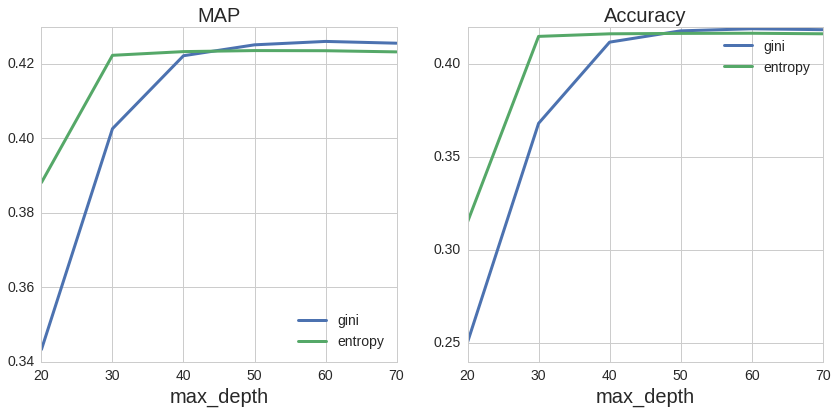

In [62]:
# plot the results
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(d_range, mape_gini, label="gini", linewidth=3)
plt.plot(d_range, mape_entropy, label="entropy", linewidth=3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.title('MAP', fontsize=20)
plt.xlabel('max_depth', fontsize=20)
plt.subplot(1,2,2)
plt.plot(d_range, accuracy_gini, label="gini", linewidth=3)
plt.plot(d_range, accuracy_entropy, label="entropy", linewidth=3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.title('Accuracy', fontsize=20)
plt.xlabel('max_depth', fontsize=20)

As we see from the plots this tree classifier reaches the maximum of the performance while working with the entropy criterion and max_depth = 30. Let's evaluate the metrics of this classifier with this best paramneters using 3-fold cross-validation.

In [87]:
clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth=30)
accuracy = cross_validation.cross_val_score(clf,x,y,scoring='accuracy')
print('Accuracy CV: '+str(accuracy.mean()))

Accuracy CV: 0.289720999503


In [88]:
clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth=30)
mape = cross_validation.cross_val_score(clf,x,y,scoring=map_scoring)
print('MAP CV: '+str(mape.mean()))

MAP CV: 0.296226364267


Now, let's try other methods. What about boosting?

In [102]:
clf = ensemble.AdaBoostClassifier(n_estimators=100)
clf.fit(X_test,y_test)
mape = map_scoring(clf,X_test,y_test)
accuracy = metrics.accuracy_score(clf.predict(X_test), y_test)
print('Accuracy CV: '+str(accuracy.mean()))
print('MAP CV: '+str(mape.mean()))

Accuracy CV: 0.02845
MAP CV: 0.0624091666667


Actually, the result is anomalously bad. In some cases, it is shown, that boosting becomes very fragile and fails on classes with slight noise. It seems to be our case.
So, out-of-the-box methods give mixed results

Actually, after studying other results on Kaggle, we can say, that this result (trees) can't be improved too much.
There is a lot of categorical data, which does not give clear partitions to classes and limits our methods of analysis.
Luckily, Trees support CART algorith, so we get at least some results.

Now, we can try picking combinations of features and different classifiers to try and find better solutions

Let's try naive bayes with few cathegorical features:
We pick such features as: destination type, month, inclusion in a package, and number of adults/children.
We use one-hot encoding to categorise all data for use in NB classifier.
The logic is that we analyse categorical features, generally describing the hotel

In [58]:
clf = naive_bayes.MultinomialNB()
enc = OneHotEncoder()
x_nb = np.array(x)[:,[8,10,11,13,14,29]]
enc.fit(x_nb)
x_enc = enc.transform(x_nb)

In [60]:
accuracy = cross_validation.cross_val_score(clf,x_enc,y,scoring='accuracy')
print('Accuracy CV: '+str(accuracy.mean()))
mape = cross_validation.cross_val_score(clf,x_enc,y,scoring=map_scoring)
print('MAP CV: '+str(mape.mean()))

Accuracy CV: 0.214415046198
MAP CV: 0.333270388911


Actually, not so bad for simple Bayes predictor.

So far, trees look like the best option. However, we can try combining different weak predictors to form a Vote classifier. Same as tree, it should approximate any distribution. We have already used naive bayes classifier to study destination properties, we can also try learning on few continious features we have-hidden vatiables from destination id and distance measures.
Let's try something new and see how QDA fare
We have picked the continuous part of the data, so it should bring some improvement to random guess

In [43]:
clf = QuadraticDiscriminantAnalysis()
xlog=np.array(x)[:,[6,19,20,21,22,23]]

In [94]:
accuracy = cross_validation.cross_val_score(clf,xlog,y,scoring='accuracy')
clf.fit(X_test,y_test)
mape = map_scoring(clf,X_test,y_test)
accuracy = metrics.accuracy_score(clf.predict(X_test), y_test)
print('Accuracy CV: '+str(accuracy.mean()))
print('MAP CV: '+str(mape.mean()))

/usr/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy CV: 0.05025
MAP CV: 0.0772608333333


We can see that it is pretty weak a classifier alone, but combined with other we may have something better

finally, we can evaluate geographic features of user and hotel by growing a small tree.
We evaluate location of the user and hotel

In [44]:
x_tree = x.ix[:,[5,16,17,30]]

In [98]:
clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth=30)
accuracy = cross_validation.cross_val_score(clf,x_tree,y,scoring='accuracy')
print('Accuracy CV: '+str(accuracy.mean()))
mape = cross_validation.cross_val_score(clf,x_tree,y,scoring=map_scoring)
print('MAP CV: '+str(mape.mean()))

Accuracy CV: 0.16562969942
MAP CV: 0.203781575196


Having 3 classifiers, we can combine them to make some voting rule. In this case, we just sum the predictions and choose the best.
The choise of models, and decision rule is quite random, but it works even that way!
We have significant improvement over the best classifier of that 3.

In [64]:
def Voting_class(x,X_train,X_test,y_train,y_test):
    cl1 = naive_bayes.MultinomialNB()
    x_nb = np.array(x)[:,[8,10,11,13,14,29]]
    enc.fit(x_nb)
    x_tr = X_train.ix[:,[8,10,11,13,14,29]]
    x_enc = enc.transform(x_tr)
    cl1.fit(x_enc,y_train)
    cl2 = clf = QuadraticDiscriminantAnalysis()
    xqd=np.array(X_train)[:,[6,19,20,21,22,23]]
    cl2.fit(xqd,y_train)
    cl3 = tree.DecisionTreeClassifier(criterion = "entropy", max_depth=30)
    x_tree = X_train.ix[:,[5,16,17,30]]
    cl3.fit(x_tree,y_train)
    xt_nb = enc.transform(np.array(X_test)[:,[8,10,11,13,14,29]])
    xt_qd = np.array(X_test)[:,[6,19,20,21,22,23]]
    xt_t = X_test.ix[:,[5,16,17,30]]
    Predict = np.add(np.add(cl1.predict_proba(xt_nb),cl2.predict_proba(xt_qd)),cl3.predict_proba(xt_t))
    return Predict

In [65]:
votes = Voting_class(x,X_train,X_test,y_train,y_test)

In [66]:
# accuracy computing for voting classifier
y_pred = []
for i in range(len(y_test)):
    index, value = max(enumerate(votes[i]), key=operator.itemgetter(1))
    y_pred.append(index)
metrics.accuracy_score(np.array(y_pred),np.array(y_test))

0.253915

In [67]:
# map computong for voting classifier
classes_true = []
for cl in y_test:
    classes_true.append([cl, cl, cl, cl, cl]) 
classes_pred = []
for pred in votes:
    classes_pred.append(np.argsort(pred)[::-1][:5])
mapk(classes_true, classes_pred)

0.36041224999999993

**Conclusion**

Having compared classifiers, we admit that the problem is not the most suited for generally used ML methods, but we still managed to make two decent classifiers-a decision tree and voting rule, and confirmed on practically that ensemble voting actually gives good improvement over classifier

There is the summary table with the experiments' results for the different classifiers is given below.

In [3]:
results = [[0.289720999503, 0.02845, 0.214415046198, 0.05025, 0.253915],
           [0.296226364267, 0.0624091666667, 0.333270388911, 0.0772608333333, 0.36041]]
pd.DataFrame(results, index = ['accuracy', 'map'], columns=['Decision Tree', 'AdaBoost', 'Naive Bayes', 'QDA', 'Voting'])

,Decision Tree,AdaBoost,Naive Bayes,QDA,Voting
accuracy,0.289721,0.028450,0.214415,0.050250,0.253915
map,0.296226,0.062409,0.333270,0.077261,0.360410
